In [34]:
!nvidia-smi

Tue Jun  4 13:46:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#import libraries w data

In [35]:
!pip install rasterio

In [36]:
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os
import io
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#data

In [37]:
import pandas as pd
file_path = '/content/drive/MyDrive/DATA/test_train.csv'
pd.read_csv(file_path)
pd.read_csv(file_path).shape
print(pd.read_csv(file_path).shape)
print(pd.read_csv(file_path).head())

(2601, 6)
   FID  Shape Crop_Type  GRIDCODE   UTM_E    UTM_N
0    0  Point     Wheat         1  592692  3950680
1    1  Point     Wheat         1  592763  3950690
2    2  Point     Wheat         1  592727  3950620
3    3  Point     Wheat         1  592659  3950580
4    4  Point     Wheat         1  592587  3950560


In [38]:
pd.read_csv(file_path)

,FID,Shape,Crop_Type,GRIDCODE,UTM_E,UTM_N
0,0,Point,Wheat,1,592692,3950680
1,1,Point,Wheat,1,592763,3950690
2,2,Point,Wheat,1,592727,3950620
3,3,Point,Wheat,1,592659,3950580
4,4,Point,Wheat,1,592587,3950560
...,...,...,...,...,...,...
2596,2596,Point,Other large-scale farming,0,592744,3896110
2597,2597,Point,Other large-scale farming,0,592486,3883980
2598,2598,Point,Other large-scale farming,0,591024,3883880
2599,2599,Point,Natural vegetation,3,609077,3940510


#preprocces

#architecture

Epoch 1/100
17/17 [==============================] - 3s 29ms/step - loss: 6.3626 - accuracy: 0.3236 - val_loss: 5.4835 - val_accuracy: 0.6027
Epoch 2/100
 9/17 [==============>...............] - ETA: 0s - loss: 5.1688 - accuracy: 0.4809

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 0s 13ms/step - loss: 4.8779 - accuracy: 0.4933 - val_loss: 4.0377 - val_accuracy: 0.5470
Epoch 3/100
17/17 [==============================] - 0s 13ms/step - loss: 3.6473 - accuracy: 0.5562 - val_loss: 2.9369 - val_accuracy: 0.7965
Epoch 4/100
17/17 [==============================] - 0s 12ms/step - loss: 2.7891 - accuracy: 0.6293 - val_loss: 2.1939 - val_accuracy: 0.8119
Epoch 5/100
17/17 [==============================] - 0s 14ms/step - loss: 2.2374 - accuracy: 0.6481 - val_loss: 1.7518 - val_accuracy: 0.7985
Epoch 6/100
17/17 [==============================] - 0s 13ms/step - loss: 1.7980 - accuracy: 0.6880 - val_loss: 1.3864 - val_accuracy: 0.9040
Epoch 7/100
17/17 [==============================] - 0s 11ms/step - loss: 1.5392 - accuracy: 0.6899 - val_loss: 1.1747 - val_accuracy: 0.8637
Epoch 8/100
17/17 [==============================] - 0s 9ms/step - loss: 1.3129 - accuracy: 0.7346 - val_loss: 0.9520 - val_accuracy: 0.9789
Epoch 9/100
17/17 [

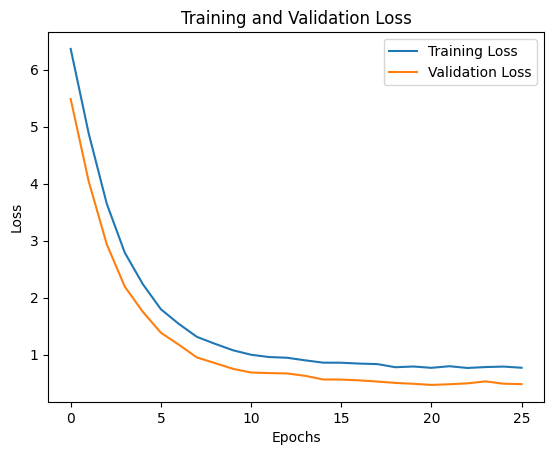

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


file_path = '/content/drive/MyDrive/DATA/test_train.csv'
df = pd.read_csv(file_path)


df['Crop_Type'].replace({'Wheat': 1.0, 'Other large-scale farming': 2.0, 'Natural vegetation': 3.0, 'Perennial crops': 4.0}, inplace=True)
df['Shape'].replace({'Point': 1.1}, inplace=True)

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['Shape'])

# Split features and target
X = df.drop(['Crop_Type'], axis=1)
y = df['Crop_Type']

# Encode target variable 'Crop_Type' using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#model architecture
model = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(0.5, input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, checkpoint])

# Evaluate 
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
loss_df = pd.DataFrame({'train_loss': train_loss, 'val_loss': val_loss})
loss_df.to_csv('loss_values.csv', index=False)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [45]:
import os
save_dir = '/content/drive/MyDrive/DATA/saved_models'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, 'best_model.h5')
model.save(model_path)


In [46]:
import tensorflow as tf
best_model = tf.keras.models.load_model(model_path)
predictions = best_model.predict(X_test)
predicted_classes = tf.argmax(predictions, axis=1)
print(predicted_classes.numpy())


17/17 [==============================] - 0s 2ms/step
[2 2 2 2 1 1 2 1 3 2 3 0 0 0 0 0 2 2 3 3 2 1 1 1 1 1 3 0 3 0 1 1 3 3 0 3 1
 0 1 1 3 0 2 0 2 1 0 2 3 2 1 3 3 2 2 1 3 0 3 0 0 0 1 2 1 3 2 3 0 1 2 0 3 0
 2 0 1 3 2 3 0 1 0 3 1 1 3 3 0 0 3 3 3 0 2 2 1 1 3 0 2 2 0 2 0 3 1 3 3 3 0
 2 2 2 3 2 2 1 2 2 3 3 0 0 2 3 3 2 0 1 1 0 2 3 2 3 3 1 1 3 0 1 1 1 3 1 0 1
 1 3 2 3 0 1 0 1 2 0 3 1 3 2 2 3 2 0 2 0 1 1 1 1 3 3 3 3 2 0 3 1 2 0 0 3 2
 2 3 3 3 0 0 1 3 3 1 1 2 3 2 3 0 0 1 3 3 2 1 0 2 0 1 2 2 3 2 0 2 1 2 0 1 2
 0 2 1 2 3 3 1 1 0 3 2 1 3 2 1 2 2 3 2 2 3 1 0 0 3 3 1 0 3 2 2 3 1 2 3 1 2
 2 1 3 0 1 3 0 3 2 2 1 3 0 0 0 0 1 0 2 0 2 1 1 2 0 1 1 3 1 2 3 2 0 2 3 1 1
 2 1 2 2 2 1 0 0 3 1 1 1 0 0 2 1 3 3 1 1 3 3 2 0 2 1 2 1 0 2 1 0 0 1 2 2 0
 2 1 1 3 3 1 1 1 2 0 3 1 2 0 1 2 2 1 1 0 1 1 1 2 0 3 3 2 0 1 3 1 0 3 2 3 1
 3 3 2 0 3 0 0 1 1 3 0 0 2 0 2 1 2 3 3 3 1 3 2 0 3 0 1 2 3 3 3 3 1 3 0 1 0
 2 1 1 0 0 2 2 1 1 2 1 3 2 3 2 1 1 2 3 2 3 1 0 0 3 3 3 1 2 2 3 2 0 0 2 1 1
 2 2 1 3 2 2 0 1 1 0 3 0 0 1 3 2 3 1 0 2 1 1 2 

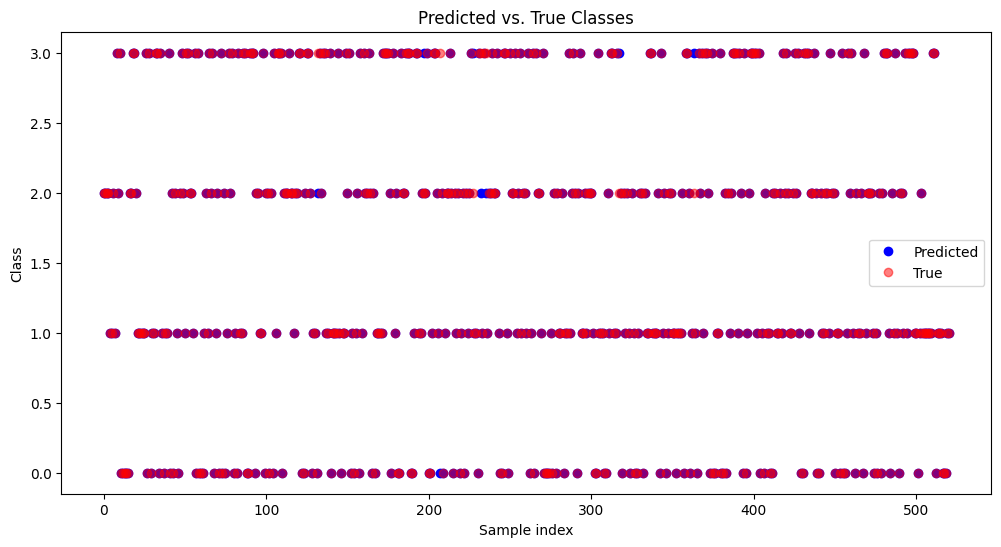

In [47]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 6))
plt.plot(predicted_classes, 'bo', label='Predicted')
plt.plot(y_test, 'ro', alpha=0.5, label='True')
plt.xlabel('Sample index')
plt.ylabel('Class')
plt.title('Predicted vs. True Classes')
plt.legend()
plt.show()


In [48]:
!pip install geopandas shapely

In [51]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
file_path = '/content/drive/MyDrive/DATA/test_train.csv'
df = pd.read_csv(file_path)
df['Shape'] = 1.1 
df.rename(columns={'UTM_E': 'longitude', 'UTM_N': 'latitude'}, inplace=True)
predicted_classes = df['Crop_Type']
predictions_df = pd.DataFrame(predicted_classes, columns=['Predicted_Class'])
results_df = pd.concat([df, predictions_df], axis=1)
results_csv_path = '/content/drive/MyDrive/DATA/predictions.csv'
results_df.to_csv(results_csv_path, index=False)

# Convert points to a shapefile
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(results_df, geometry=geometry)
shapefile_path = '/content/drive/MyDrive/DATA/predictions.shp'
geo_df.to_file(shapefile_path, driver='ESRI Shapefile')
print("Shapefile saved to:", shapefile_path)

<ipython-input-51-cc623ebeeb91>:34: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  geo_df.to_file(shapefile_path, driver='ESRI Shapefile')


Shapefile saved to: /content/drive/MyDrive/DATA/predictions.shp


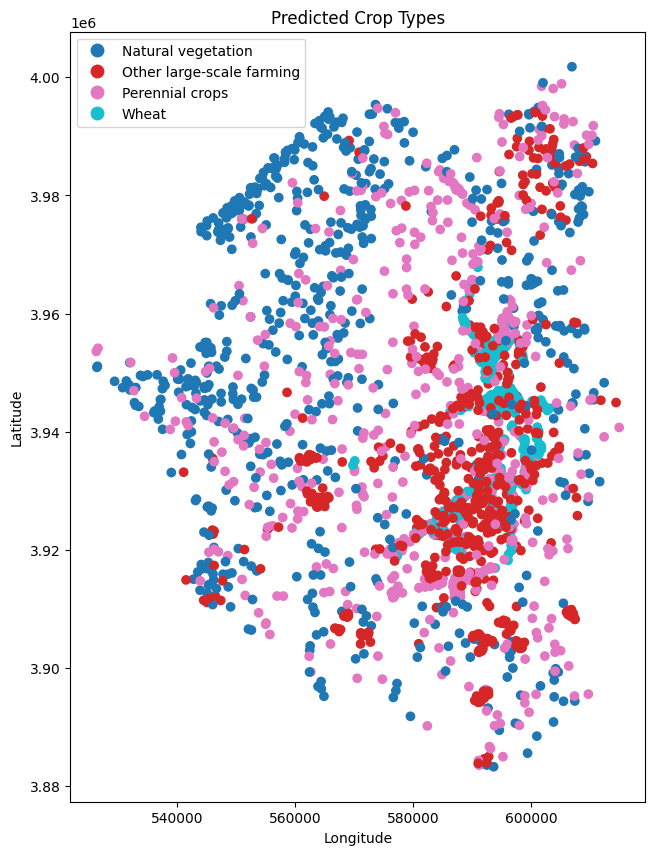

In [53]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
shapefile_path = '/content/drive/MyDrive/DATA/predictions.shp'
geo_df = gpd.read_file(shapefile_path)

# Plot the data
geo_df.plot(figsize=(10, 10), column='Crop_Type', legend=True)
plt.title('Predicted Crop Types')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
